In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import mlflow
import datetime
import pytz
import glob
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.stochastic import sample
import numpy as np
from mlflow.tracking import MlflowClient
import os

random_seed = 99
thailand_timezone = pytz.timezone('Asia/Bangkok')

mlflow.set_tracking_uri('http://127.0.0.1:50000')
mlflow.set_experiment('NYC-TAXI_TRIP-DURATION-PREDICTION')

2023/07/04 11:25:24 INFO mlflow.tracking.fluent: Experiment with name 'NYC-TAXI_TRIP-DURATION-PREDICTION' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1688444724271, experiment_id='1', last_update_time=1688444724271, lifecycle_stage='active', name='NYC-TAXI_TRIP-DURATION-PREDICTION', tags={}>

In [11]:
file_path = "../data/raw/2020/*.parquet"
df = pd.concat(map(pd.read_parquet, glob.glob(file_path)))
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda x: round(x.total_seconds() / 60, 2))
df[['PULocationID', 'DOLocationID']] = df[['PULocationID', 'DOLocationID']].astype(str)
df = df[(df['duration'] >= 0) & (df['duration'] <= 70)]
print(df.shape)
df.head()

(1717365, 21)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2020-03-01 00:20:18,2020-03-01 00:45:29,N,1.0,41,13,1.0,8.24,26.5,...,0.5,7.64,0.0,None,0.3,38.19,1.0,1.0,2.75,25.18
1,2,2020-03-01 00:15:42,2020-03-01 00:44:36,N,1.0,181,107,1.0,4.87,21.0,...,0.5,0.00,0.0,None,0.3,25.05,2.0,1.0,2.75,28.90
2,2,2020-03-01 00:36:18,2020-03-01 00:41:03,N,1.0,41,166,1.0,0.69,5.0,...,0.5,0.00,0.0,None,0.3,6.30,2.0,1.0,0.00,4.75
3,1,2020-03-01 00:22:14,2020-03-01 00:32:57,N,1.0,129,7,1.0,1.80,9.0,...,0.5,0.00,0.0,None,0.3,10.30,2.0,1.0,0.00,10.72
4,2,2020-03-01 00:07:22,2020-03-01 00:14:16,N,1.0,74,152,1.0,1.25,7.0,...,0.5,2.49,0.0,None,0.3,10.79,1.0,1.0,0.00,6.90


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1717365 entries, 0 to 63109
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   lpep_pickup_datetime   datetime64[ns]
 2   lpep_dropoff_datetime  datetime64[ns]
 3   store_and_fwd_flag     object        
 4   RatecodeID             float64       
 5   PULocationID           object        
 6   DOLocationID           object        
 7   passenger_count        float64       
 8   trip_distance          float64       
 9   fare_amount            float64       
 10  extra                  float64       
 11  mta_tax                float64       
 12  tip_amount             float64       
 13  tolls_amount           float64       
 14  ehail_fee              object        
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  payment_type           float64       
 18  trip_type              float6

In [13]:
X = df[['PULocationID', 'DOLocationID', 'trip_distance']]
y = df['duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1373892, 3)
Test data shape: (343473, 3)


In [14]:
# Define the regression models
models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge(random_state=random_seed)),
    ("Lasso", Lasso(random_state=random_seed)),
    ("ElasticNet", ElasticNet(random_state=random_seed)),
    # ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=random_seed)), 
    # ("RandomForestRegressor", RandomForestRegressor(random_state=random_seed)),
    ("XGBRegressor", XGBRegressor(random_state=random_seed)),
    ("LGBMRegressor", LGBMRegressor(random_state=random_seed)),
    ("CatBoostRegressor", CatBoostRegressor(random_state=random_seed, verbose=0)),
    # ("SVR", SVR()),
    # ("KNeighborsRegressor", KNeighborsRegressor()),
    ("AdaBoostRegressor", AdaBoostRegressor(random_state=random_seed)),
    ("GradientBoostingRegressor", GradientBoostingRegressor(random_state=random_seed)),
]

for name, model in models:
    current_datetime = datetime.datetime.now(thailand_timezone).strftime("%Y%m%dT%H%M%S")
    run_name = name + current_datetime
    with mlflow.start_run(run_name=run_name) as run:
        pipeline = Pipeline([('convert_to_dict', FunctionTransformer(lambda x: x.to_dict(orient='records'))),
                             ('vectorizer', DictVectorizer()),
                             (name, model)])
        
        scores = cross_val_score(pipeline, X_train, y_train, cv=5,
                                 scoring='neg_root_mean_squared_error')

        train_rmse_mean = (-scores).mean()
        train_rmse_std = (-scores).std()

        pipeline.fit(X_train, y_train)
        test_predictions = pipeline.predict(X_test)
        test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

        params = model.get_params()
        
        mlflow.set_tags({"stage": "model_selection", "model": name})
        mlflow.log_params(params)
        mlflow.log_metric("Train RMSE MEAN", train_rmse_mean)
        mlflow.log_metric("Train RMSE STD", train_rmse_std)
        mlflow.log_metric("Test RMSE", test_rmse)

        # final_model = pipeline.fit(X, y)
        # mlflow.sklearn.log_model(final_model, "model")

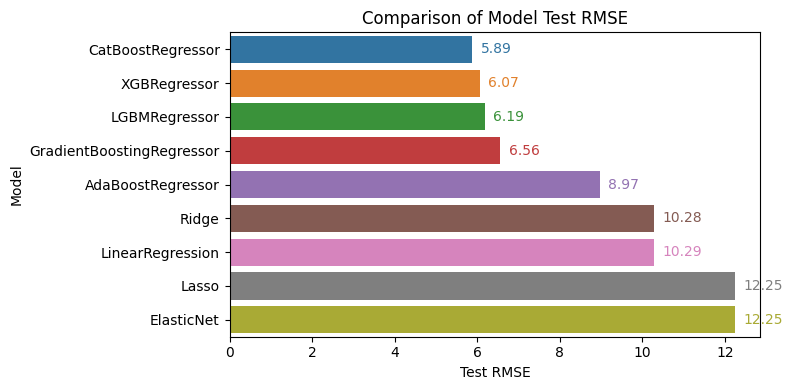

In [15]:
# Perform a search using mlflow and retrieve the experiment results
df_experiment = mlflow.search_runs(filter_string="tags.stage='model_selection'")
columns = ['tags.model', 'metrics.Train RMSE MEAN', 'metrics.Test RMSE']
df_experiment = df_experiment[columns]
df_experiment.sort_values(by=['metrics.Test RMSE'], inplace=True)
df_experiment

# Set the figure size
plt.figure(figsize=(8, 4))

# Create the bar plot using seaborn
ax = sns.barplot(x='metrics.Test RMSE', y='tags.model', data=df_experiment)

# Add labels and title
plt.xlabel('Test RMSE')
plt.ylabel('Model')
plt.title('Comparison of Model Test RMSE')

# Add label numbers to each bar
for i, v in enumerate(round(df_experiment['metrics.Test RMSE'], 2)):
    bar_color = ax.patches[i].get_facecolor()
    ax.text(v + 0.2, i, str(v), color=bar_color, ha='left', va='center')

# Display the plot
plt.tight_layout()
plt.show()

In [16]:
def objective(params):
    current_datetime = datetime.datetime.now(thailand_timezone).strftime("%Y%m%dT%H%M%S")
    model_name = 'CatBoostRegressor'
    run_name = model_name + current_datetime
    with mlflow.start_run(run_name=run_name) as run:
        # Instantiate the model with the hyperparameters
        model = CatBoostRegressor(**params, random_state=random_seed, verbose=False)
        pipeline = Pipeline([('convert_to_dict', FunctionTransformer(lambda x: x.to_dict(orient='records'))),
                             ('vectorizer', DictVectorizer()),
                             (model_name, model)])

        # Fit the model on the training data
        scores = cross_val_score(pipeline, X_train, y_train, cv=5,
                                 scoring='neg_root_mean_squared_error')
        train_rmse_mean = (-scores).mean()
        train_rmse_std = (-scores).std()

        pipeline.fit(X_train, y_train)
        test_predictions = pipeline.predict(X_test)
        test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

        params = model.get_params()
        mlflow.set_tags({"stage": "hyperparameter_tune", "model": model_name})
        mlflow.log_params(params)
        mlflow.log_metric("Train RMSE MEAN", train_rmse_mean)
        mlflow.log_metric("Train RMSE STD", train_rmse_std)
        mlflow.log_metric("Test RMSE", test_rmse)

        return train_rmse_mean

# Define the search space for hyperparameters
params_grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'depth': hp.quniform('depth', 3, 10, 1),
    'iterations': hp.choice('iterations', [1000, 2000, 3000]),
}

tpe_search = fmin(
    fn=objective,
    space=params_grid,
    max_evals=5,
    algo=tpe.suggest
)

100%|██████████| 5/5 [45:21<00:00, 544.38s/trial, best loss: 5.65643000159979] 


In [17]:
all_experiments = mlflow.search_runs(filter_string="status='FINISHED'")
best_experiment = all_experiments.loc[[all_experiments['metrics.Train RMSE MEAN'].idxmin()]]
best_run_id = best_experiment['run_id'].values[0]
best_model = best_experiment['tags.model'].values[0]
best_rmse = best_experiment['metrics.Train RMSE MEAN'].values[0]
best_parameter = best_experiment[best_experiment.columns[best_experiment.notna().all()]]
best_parameter = best_parameter.apply(pd.to_numeric, errors='ignore')
best_parameter = best_parameter.replace({'True': True, 'False': False})
best_parameter = best_parameter.filter(regex=r'^params')  \
                                .rename(columns=lambda x: x.replace('params.', ''))  \
                                .to_dict(orient='records')[0]

print(f"best run id: {best_run_id}")
print(f"best model: {best_model}")
print(f"best parameter: {best_parameter}")
print(f"best rmse: {best_rmse}")

best run id: 487b4de529a24f0a8991161365925793
best model: CatBoostRegressor
best parameter: {'verbose': False, 'random_state': 99, 'iterations': 3000, 'depth': 8.0, 'loss_function': 'RMSE', 'learning_rate': 0.1039907738383601}
best rmse: 5.65643000159979


In [18]:
#Train final model
with mlflow.start_run(run_id=best_run_id) as run:
    model = CatBoostRegressor(**best_parameter)
    pipeline = Pipeline([('convert_to_dict', FunctionTransformer(lambda x: x.to_dict(orient='records'))),
                         ('vectorizer', DictVectorizer()),
                         (best_model.lower() , model)])
    final_model = pipeline.fit(X, y)
    mlflow.sklearn.log_model(final_model, "model")

In [24]:
# Register model
model_name = "duration_predict"
model_uri = f"runs:/{best_run_id}/model"
mlflow.register_model(model_uri, model_name)

Successfully registered model 'duration_predict'.
2023/07/04 13:21:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: duration_predict, version 1
Created version '1' of model 'duration_predict'.


<ModelVersion: aliases=[], creation_timestamp=1688451694839, current_stage='None', description='', last_updated_timestamp=1688451694839, name='duration_predict', run_id='487b4de529a24f0a8991161365925793', run_link='', source='mlflow-artifacts:/1/487b4de529a24f0a8991161365925793/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [26]:
# Change stage to production
client = MlflowClient()
client.transition_model_version_stage(name="duration_predict", version=1, stage="Production")

<ModelVersion: aliases=[], creation_timestamp=1688451694839, current_stage='Production', description='', last_updated_timestamp=1688451827644, name='duration_predict', run_id='487b4de529a24f0a8991161365925793', run_link='', source='mlflow-artifacts:/1/487b4de529a24f0a8991161365925793/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [31]:
# Load model
stage = "Production"
model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{stage}")
model.predict(X_test)

array([11.2426258 , 22.22935058,  0.81821142, ..., 25.62375864,
       25.49175269, 14.80068091])